# TF-Slim Walkthrough

This notebook will walk you through the basics of using TF-Slim to define, train and evaluate neural networks on various tasks. It assumes a basic knowledge of neural networks. 

## Table of contents

<a href="#Install">Installation and setup</a><br>
<a href='#MLP'>Creating your first neural network with slim</a><br>
<a href='#SlimData'>Slim datasets</a><br>
<a href='#CNN'>Training a convolutional neural network (CNN)</a><br>
<a href='#Pretained'>Using pre-trained models</a><br>


## Installation and setup
<a id='Install'></a>

As of 8/28/16, the latest stable release of TF is r0.10, which does not contain the latest version of slim.
To obtain the latest version of slim, please install the most recent nightly build of TF
as explained [here](https://github.com/nathansilberman/models/tree/master/slim#getting-started).

To use slim for image classification (as we do in this notebook), you also have to install the slim image models library from [here]https://github.com/tensorflow/models/tree/master/slim). Let's suppose you install this into a directory called TF_MODELS. Then you should change directory to  TF_MODELS/slim **before** running this notebook, so that all the files are on the path.

To check you've got these two steps to work, just execute the cell below. It it complains about unknown modules, restart the notebook after moving to the slim models directory.


In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

# Main slim library
import tensorflow.contrib.slim as slim 

# Slim image models library
import datasets.dataset_utils as utils
import datasets.flowers as flowers # Dataset we will use in this notebook
from nets.inception import inception_v3 
import models.inception_preprocessing as pp # Preprocessor we will use in this notebook



## Creating your first neural network with slim
<a id='MLP'></a>

Below we give some code to create a simple multilayer perceptron (MLP)  which can be used
for regression problems. The model has 2 hidden layers.
The output is a single node. 
When this function is called, it will create various nodes, and silently add them to whichever global TF graph is currently in scope. When a node which corresponds to a layer with adjustable parameters (eg., a fully connected layer) is created, additional parameter variable nodes are silently created, and added to the graph. (We will discuss how to train the parameters later.)

We use variable scope to put all the nodes under a common name,
so that the graph has some hierarchical structure.
This is useful when we want to visualize the TF graph in tensorboard, or if we want to query related
variables. 
The fully connected layers all use the same L2 weight decay and ReLu activations, as specified by **arg_scope**. (However, the final layer overrides these defaults, and uses an identity activation function.)

We also illustrate how to add a dropout layer after the first fully connected layer (FC1). Note that at test time, 
we do not drop out nodes, but instead use the average activations; hence we need to know whether the model is being
constructed for training or testing, since the computational graph will be different in the two cases
(although the variables, storing the model parameters, will be shared, since they have the same name/scope).

In [25]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
  """Creates the regression model.
  
  Args:
    input_node: A node that yields a `Tensor` of size [batch_size, dimensions].
    is_training: Whether or not we're currently training the model.
    scope: An optional variable_op scope for the model.
  
  Returns:
    output_node: 1-D `Tensor` of shape [batch_size] of responses.
    nodes: A dict of nodes representing the hidden layers.
  """
  with tf.variable_op_scope([input_node], scope):
    nodes = {}
    # Set the default weight _regularizer and acvitation for each fully_connected layer.
    with slim.arg_scope([slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_regularizer=slim.l2_regularizer(0.01)):
      
      # Creates a fully connected layer from the inputs with 10 hidden units.
      fc1_node = slim.fully_connected(inputs, 10, scope='fc1')
      nodes['fc1'] = fc1_node
        
      # Adds a dropout layer to prevent over-fitting.
      dropout_node = slim.dropout(fc1_node, 0.8, is_training=is_training)
      
      # Adds another fully connected layer with 5 hidden units.
      fc2_node = slim.fully_connected(dropout_node, 5, scope='fc2')
      nodes['fc2'] = fc2_node
      
      # Creates a fully-connected layer with a single hidden unit. Note that the
      # layer is made linear by setting activation_fn=None.
      prediction_node = slim.fully_connected(fc2_node, 1, activation_fn=None, scope='prediction')
      nodes['out'] = prediction_node

      return prediction_node, nodes

### Let's create the model and examine its structure.

We create a TF graph and call regression_model(), which adds nodes (tensors) to the graph. We then examine their shape, and print the names of all the model variables which have been implicitly created inside of each layer. We see that the names of the variables follow the scopes that we specified.

In [26]:
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
  # Dummy placeholders for arbitrary number of 1d inputs and outputs
  input_node = tf.placeholder(tf.float32, shape=(None, 1))
  output_node = tf.placeholder(tf.float32, shape=(None, 1))
  
  # Build model
  prediction_node, all_nodes = regression_model(input_node)
 
  # Print name and shape of each tensor.
  print "Layers"
  for k, v in all_nodes.iteritems():
    print 'name = {}, shape = {}'.format(v.name, v.get_shape())
    
  # Print name and shape of parameter nodes  (values not yet initialized)
  print "Parameters"
  for v in slim.get_model_variables():
    print 'name = {}, shape = {}'.format(v.name, v.get_shape())
       

Layers
name = deep_regression/fc1/Relu:0, shape = (?, 10)
name = deep_regression/fc2/Relu:0, shape = (?, 5)
name = deep_regression/prediction/BiasAdd:0, shape = (?, 1)
Parameters
name = deep_regression/fc1/weights:0, shape = (1, 10)
name = deep_regression/fc1/biases:0, shape = (10,)
name = deep_regression/fc2/weights:0, shape = (10, 5)
name = deep_regression/fc2/biases:0, shape = (5,)
name = deep_regression/prediction/weights:0, shape = (5, 1)
name = deep_regression/prediction/biases:0, shape = (1,)


### Let's create some 1d regression data .

We will train and test the model on some noisy observations of a nonlinear function.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


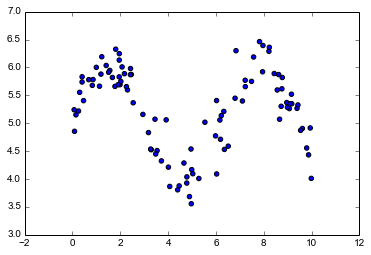

In [27]:
def produce_batch(batch_size, noise=0.3):
  xs = np.random.random(size=[batch_size, 1]) * 10
  ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
  return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(100)
x_test, y_test = produce_batch(100)
plt.scatter(x_train, y_train)

### Let's fit the model to the data

The user has to specify the loss function and the optimizer, and slim does the rest.
In particular,  the slim.learning.train function does the following:

- For each iteration, evaluate the train_op, which updates the parameters using the optimizer applied to the current minibatch. Also, update the global_step.
- Occasionally store the model checkpoint in the specified directory. This is useful in case your machine crashes  - then you can simply restart from the specified checkpoint.

In [28]:
# Everytime we run training, we need to store the model checkpoint in a new directory,
# in case anything has changed.
import time
ts = time.time()
ckpt_dir = '/tmp/tf/regression_model/model{}'.format(ts) # Place to store the checkpoint.
print('Saving to {}'.format(ckpt_dir))

Saving to /tmp/tf/regression_model/model1472425340.99


In [29]:
def convert_data_to_tensors(x, y):
  input_tensor = tf.constant(x)
  input_tensor.set_shape([None, 1])
  output_tensor = tf.constant(y)
  output_tensor.set_shape([None, 1])
  return input_tensor, output_tensor

In [30]:
graph = tf.Graph() # new graph
with graph.as_default():
  input_node, output_node = convert_data_to_tensors(x_train, y_train)

  # Make the model.
  prediction_node, nodes = regression_model(input_node, is_training=True)
 
  # Add the loss function to the graph.
  loss_node = slim.losses.sum_of_squares(prediction_node, output_node)
  # The total loss is the uers's loss plus any regularization losses.
  total_loss_node = slim.losses.get_total_loss()

  # Create some summaries to visualize the training process:
  ## TODO: add summaries.py to 3p
  #slim.summaries.add_scalar_summary(total_loss, 'Total Loss', print_summary=True)
  
  # Specify the optimizer and create the train op:
  optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
  train_op_node = slim.learning.create_train_op(total_loss_node, optimizer) 

  # Run the training inside a session.
  final_loss = slim.learning.train(
    train_op_node,
    logdir=ckpt_dir,
    number_of_steps=500,
    save_summaries_secs=1)
  
print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

('Finished training. Last batch loss:', 0.46741363)
Checkpoint saved in /tmp/tf/regression_model/model1472425340.99


### Training with multiple loss functions.

Sometimes we have multiple objectives we want to simultaneously optimize.
In slim, it is easy to add more losses, as we show below. (We do not optimize the total loss in this example,
but we show how to compute it.)

In [31]:
graph = tf.Graph()  # Make a new graph
with graph.as_default():
    input_node, output_node = convert_data_to_tensors(x_train, y_train)
    prediction_node, nodes = regression_model(input_node, is_training=True)

    # Add multiple loss nodes.
    sum_of_squares_loss_node = slim.losses.sum_of_squares(prediction_node, output_node)
    absolute_difference_loss_node = slim.losses.absolute_difference(prediction_node, output_node)

    # The following two ways to compute the total loss are equivalent
    regularization_loss_node = tf.add_n(slim.losses.get_regularization_losses())
    total_loss1_node = sum_of_squares_loss_node + absolute_difference_loss_node + regularization_loss_node

    # Regularization Loss is included in the total loss by default.
    # This is good for training, but not for testing.
    total_loss2_node = slim.losses.get_total_loss(add_regularization_losses=True)
    
    init_node = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init_node) # Will randomize the parameters.
        total_loss1, total_loss2 = sess.run([total_loss1_node, total_loss2_node])
        print('Total Loss1: %f' % total_loss1)
        print('Total Loss2: %f' % total_loss2)

        print('Regularization Losses:')
        for loss_node in slim.losses.get_regularization_losses():
            print(loss_node)

        print('Loss Functions:')
        for loss_node in slim.losses.get_losses():
            print(loss_node)

Total Loss1: 19.372726
Total Loss2: 19.372725
Regularization Losses:
Tensor("deep_regression/fc1/weights/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Tensor("deep_regression/fc2/weights/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Tensor("deep_regression/prediction/weights/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Loss Functions:
Tensor("sum_of_squares_loss/value:0", shape=(), dtype=float32)
Tensor("absolute_difference/value:0", shape=(), dtype=float32)


### Let's load the saved model and use it for prediction.

The predictive accuracy is not very good, because we used a small model,
and only trained for 500 steps, to keep the demo fast. 
Running for 5000 steps improves performance a lot.

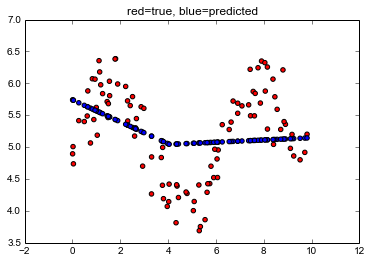

In [32]:
with tf.Graph().as_default():
    input_node, output_node = convert_data_to_tensors(x_test, y_test)
  
    # Create the model structure. (Parameters will be loaded below.)
    prediction_node, nodes = regression_model(input_node, is_training=False)

    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, true_outputs = sess.run([input_node, prediction_node, output_node])

plt.scatter(inputs, true_outputs, c='r');
plt.scatter(inputs, predictions, c='b');
plt.title('red=true, blue=predicted')

### Let's examine the learned parameters.

In [33]:
with tf.Graph().as_default():
    input_node = tf.placeholder(tf.float32, shape=(None, 1))
    output_node = tf.placeholder(tf.float32, shape=(None, 1))
    prediction_node, nodes = regression_model(input_node, is_training=False)
  
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        model_variables = slim.get_model_variables()
        for v in model_variables:
            val = sess.run(v)
            print v.name, val.shape, val


deep_regression/fc1/weights:0 (1, 10) [[  8.89307484e-02  -1.85735784e-02  -1.82460919e-01   1.11556970e-01
   -5.06562032e-02  -7.43551850e-02  -2.40475126e-02  -1.39936423e-02
    1.31928816e-01  -4.59148431e-12]]
deep_regression/fc1/biases:0 (10,) [-0.0106875  -0.04260242  0.74017632  0.02813937 -0.0597684  -0.2113885
  0.38097316 -0.04772202  0.7916041  -0.10574399]
deep_regression/fc2/weights:0 (10, 5) [[  4.44461666e-02   2.40904987e-02   5.87327294e-02   8.80799964e-02
    4.81929861e-12]
 [ -1.11180162e-12   3.12959381e-12   1.77200753e-04   9.34129579e-11
    5.78910485e-03]
 [  2.99159229e-01   3.35745364e-01   6.73383987e-03   4.57007378e-01
   -2.22929357e-12]
 [  4.04847711e-02   5.03515340e-02   6.50147200e-02   6.72186241e-02
    1.27681216e-11]
 [ -2.55614150e-12   7.95866357e-13   5.15950021e-13   5.11141858e-11
   -6.51078041e-14]
 [  5.42647958e-01  -1.75126761e-01  -3.64348978e-01  -1.52332887e-01
    9.13784802e-02]
 [  4.54699546e-01  -2.38114864e-01   1.00751832e

### Let's compute various evaluation metrics on the test set.

In slim termiology, losses are optimized, but metrics (which may not be differentiable, e.g., precision and recall) are just measured.
As an illustration, the code below computes mean squared error and mean absolute error metrics on the test set.

Each metric declaration creates several local variables (which must be initialized via tf.initialize_local_variables()) and returns both a value_op and an update_op. When evaluated, the value_op returns the current value of the metric. The update_op loads a new batch of data, runs the model, obtains the predictions and accumulates the metric statistics appropriately before returning the current value of the metric. We store these value nodes and update nodes in 2 dictionaries.

After creating the metric nodes, we can pass them to slim.evaluation.evaluation, which repeatedly evaluates these nodes the specified number of times. (This allows us to compute the evaluation in a streaming fashion across minibatches, which is usefulf for large datasets.) Finally, we print the final value of each metric.


In [34]:
with tf.Graph().as_default():
    input_node, output_node = convert_data_to_tensors(x_test, y_test)
    prediction_node, nodes = regression_model(input_node, is_training=False)

    # Specify metrics to evaluate:
    names_to_value_nodes, names_to_update_nodes = slim.metrics.aggregate_metric_map({
      'Mean Squared Error': slim.metrics.streaming_mean_squared_error(prediction_node, output_node),
      'Mean Absolute Error': slim.metrics.streaming_mean_absolute_error(prediction_node, output_node)
    })


    init_node = tf.group(
        tf.initialize_all_variables(),
        tf.initialize_local_variables())

    # Make a session which restores the old graph parameters, and then run eval.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        metric_values = slim.evaluation.evaluation(
            sess,
            num_evals=1, # Single pass over data
            init_op=init_node,
            eval_op=names_to_update_nodes.values(),
            final_op=names_to_value_nodes.values())

    names_to_values = dict(zip(names_to_value_nodes.keys(), metric_values))
    for key, value in names_to_values.iteritems():
      print('%s: %f' % (key, value))

Mean Squared Error: 19.081902
Mean Absolute Error: 4.265678


# Slim datasets
<a id='SlimData'></a>

A slim Dataset object contains a pointer to a data file, and metadata, so it knows how big the file is, what kind of data is stored in the file, etc. For example, some files contain images with labels, some also have bounding box annotations, etc. The Dataset object allows us to write generic code using the same API, regardless of the data format. 

The easiest way to create a slim Dataset is if the data is stored as a (possibly sharded)
[TFRecords file](https://www.tensorflow.org/versions/r0.10/how_tos/reading_data/index.html#file-formats), where each record contains a [tf.train.Example protocol buffer](https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/core/example/example.proto).
Slim uses a consistent convention for naming the keys and values inside each Example record. 

Once we have the data in TFRecord format, we can easily create a slim Dataset from it. Finally, we can create a slim DatasetDataProvider, which is an object which can "provide" minibatches of data on demand, using queue runners, to support high throughput parallel data processing. We illustrate this below.

For convenience, we include  scripts to convert common image datasets into slim format,
as explained [here](https://github.com/nathansilberman/tensorflow_models/tree/master/slim#datasets).
Below we give an example of how to use a slim dataset, containing a set of flower images. 

### Download the TFRecord files.


In [6]:
import datasets.dataset_utils as utils
import os
url = "http://download.tensorflow.org/data/flowers.tar.gz"
data_folder = '/tmp/flowers_tfrecords3'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
utils.download_and_uncompress_tarball(url, data_folder) 

>> Downloading flowers.tar.gz 100.0%
Successfully downloaded flowers.tar.gz 228649660 bytes.


### Convert TFRecord files to slim Dataset.

In [7]:
def get_dataset(): # We use validation set since it's smaller and hence faster for demo purposes.
    return flowers.get_split('validation', data_folder)

dataset = get_dataset() 
print ("Label set {}".format(dataset.labels_to_names.values()))
NUM_CLASSES = dataset.num_classes

# To use mnist instead, uncomment the following
#import datasets.mnist as mnist
#def get_dataset():
#    return mnist.get_split('test', data_folder)

Label set ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Display some of the data.

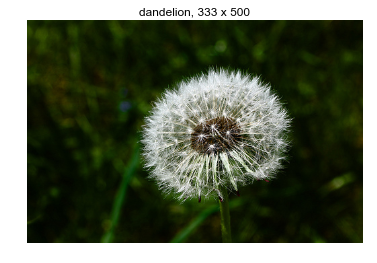

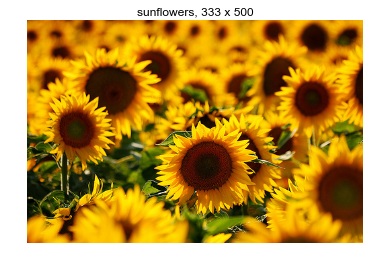

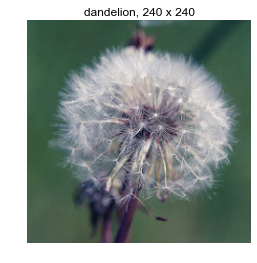

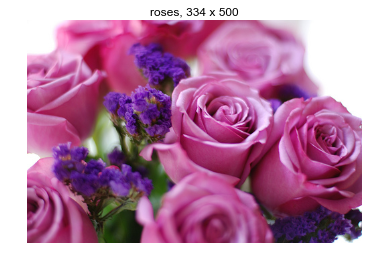

In [8]:
with tf.Graph().as_default(): 
    dataset = get_dataset() # Have to call this function again here, since adds nodes to TF graph.
    data_provider = slim.dataset_data_provider.DatasetDataProvider( # Reads in random order
        dataset, common_queue_capacity=32, common_queue_min=1)
    image_node, label_node = data_provider.get(['image', 'label'])
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in xrange(4):
                image, label_num = sess.run([image_node, label_node])
                plt.figure()
                plt.imshow(image)
                name = dataset.labels_to_names[label_num]
                label_name = '{}, {} x {}'.format(name, image.shape[0], image.shape[1])
                plt.title(label_name)
                plt.axis('off')
                plt.show()

# Convolutional neural nets (CNNs).
<a id='CNN'></a>

In this section, we show how to train an image classifier using a simple CNN.


### Define the model.

Below we define a simple CNN. Note that the output layer is linear function - we will apply softmax transformation externally to the model, either in the loss function (for training), or in the prediction function (during testing).

In [9]:
def my_cnn(images, num_classes, is_training):  # is_training is not used...
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
        return net

### Apply the model to some randomly generated images.

In [10]:
with tf.Graph().as_default():
    # The model can handle any input size because the first layer is convolutional.
    # The size of the model is determined when image_node is first passed into the my_cnn function.
    # Once the variables are initialized, the size of all the weight matrices is fixed.
    # Because of the fully connected layers, this means that all subsequent images must have the same
    # input size as the first image.
    n_images = 3
    image_node = tf.random_uniform([n_images, 28, 28, 3], maxval=1)
    
    # Create the model.
    n_classes = 10
    logits_node = my_cnn(image_node, n_classes, True)
    prob_node = tf.nn.softmax(logits_node)
  
    # Initialize all the variables (including parameters) randomly.
    init_op = tf.initialize_all_variables()
  
    with tf.Session() as sess:
        # Run the init_op, evaluate the model outputs and print the results:
        sess.run(init_op)
        probs = sess.run(prob_node)
        
print(probs.shape)  # n_images x n_classes 
print(probs)
print(np.sum(probs, 1)) # Each row sums to 1

(3, 10)
[[ 0.1470948   0.07511543  0.0730215   0.1075139   0.09492993  0.08520426
   0.10926386  0.11668897  0.11212265  0.07904463]
 [ 0.15560801  0.07532161  0.07211446  0.1020226   0.09104839  0.08515389
   0.10296939  0.12004536  0.1125701   0.08314616]
 [ 0.15255645  0.07594633  0.07153893  0.10628529  0.10113058  0.08594283
   0.10998356  0.11178344  0.10539544  0.07943724]]
[ 0.99999994  0.99999994  1.00000012]


### Train the model on a real dataset.

Make sure you run the code in the "Slim datasets" section first, so that the dataset is ready to use.

In [20]:
import models.inception_preprocessing as pp
HEIGHT = 299
WIDTH = 299
BATCH_SIZE = 32

def create_data_tensors_raw(BATCH_SIZE=32):
    dataset = get_dataset()
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, HEIGHT, WIDTH)
    image_raw = tf.squeeze(image_raw)
    image = pp.preprocess_image(image_raw, HEIGHT, WIDTH, is_training=False)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=BATCH_SIZE,
          num_threads=2,
          capacity=10 * BATCH_SIZE)
    
    return images, images_raw, labels

def create_data_tensors(BATCH_SIZE=32):
    dataset = get_dataset()
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    image = pp.preprocess_image(image_raw, HEIGHT, WIDTH, is_training=False)

    # Batch it up.
    images, labels = tf.train.batch(
          [image, label],
          batch_size=BATCH_SIZE,
          num_threads=2,
          capacity=10 * BATCH_SIZE)
    
    return images, labels

In [14]:
# This might take a few minutes.
CHECKPOINT_DIR = '/tmp/tf/model{}'.format(time.time()) 
print('Will save model to {}'.format(CHECKPOINT_DIR))

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    #images, images_raw, labels = create_data_tensors_raw()
    images, labels = create_data_tensors()
  
    # Create the model:
    logits = my_cnn(images, num_classes=NUM_CLASSES, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, NUM_CLASSES)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.scalar_summary('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=CHECKPOINT_DIR,
      number_of_steps=1, # For speed, we just do 1 epoch
      save_summaries_secs=1)
  
print('Finished training. Last batch loss {}'.format(final_loss))

Will save model to /tmp/tf/model1472509385.22


INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 1: loss = 1.6498 (28.53 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.


Finished training. Last batch loss 1.64983320236


### Evaluate some metrics.

As we discussed above, we can compute various metrics besides the loss.
Below we show how to compute prediction accuracy of the trained model, as well as top-5 classification accuracy. (The difference between evaluation and evaluation_loop is that the latter writes the results to a log directory, so they can be viewed in tensorboard.)

In [15]:
# This might take a few minutes.

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    #images, images_raw, labels = create_data_tensors_raw()
    images, labels = create_data_tensors()
    logits = my_cnn(images, num_classes=NUM_CLASSES, is_training=False)
    predictions = tf.argmax(logits, 1)

    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/Recall@5': slim.metrics.streaming_recall_at_k(logits, labels, 5),
    })
    
    # Create the summary ops such that they also print out to std output:
    summary_ops = []
    for name, value in names_to_values.iteritems():
        op = tf.scalar_summary(name, value, collections=[])
        op = tf.Print(op, [value], name)
        tf.add_to_collection(tf.GraphKeys.SUMMARIES, op)
        summary_ops.append(op)

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(CHECKPOINT_DIR)
    slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=CHECKPOINT_DIR,
        eval_op=names_to_updates.values())
    print('Done!')
    
    #summary_op=tf.merge_summary(summary_ops))

INFO:tensorflow:Starting evaluation at 2016-08-29-22:23:48


Running evaluation Loop...


INFO:tensorflow:Executing eval ops
INFO:tensorflow:Executing eval_op 1/1
INFO:tensorflow:Executing summary op
INFO:tensorflow:Finished evaluation at 2016-08-29-22:23:52


Done!


# Using pre-trained models
<a id='Pretrained'></a>

Neural nets work best when they have many parameters, making them very flexible function approximators.
However, this  means they must be trained on big datasets. Since this process is slow, we provide various pre-trained models - see the list [here](https://github.com/tensorflow/models/tree/master/slim#pre-trained-models).


You can either use these models as-is, or you can perform "surgery" on them, to modify them for some other task. For example, it is common to "chop off" the final pre-softmax layer, and replace it with a new set of weights corresponding to some new set of labels. You can then quickly fine tune the new model on a small new dataset. We illustrate this below, using inception-v3 as the base model.


### Download inception checkpoint.




In [16]:
url = "http://download.tensorflow.org/models/inception_v3_2016_08_23.tar.gz"
inception_folder = '/tmp/tf/inception-v3'
if not os.path.exists(inception_folder):
    os.makedirs(inception_folder)
utils.download_and_uncompress_tarball(url, inception_folder)

>> Downloading inception_v3_2016_08_23.tar.gz 100.0%
Successfully downloaded inception_v3_2016_08_23.tar.gz 100884926 bytes.


In [17]:
# The inception checkpoint was trained on imagenet with 1000 labels.
# However the checkpoint does not contain human readable names, so we create them here.

from six.moves import urllib
from datasets import imagenet
labels_to_names = imagenet.create_readable_names_for_imagenet()
print(len(labels_to_names))
print(labels_to_names)

1001
{0: 'background', 1: 'tench, Tinca tinca', 2: 'goldfish, Carassius auratus', 3: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 4: 'tiger shark, Galeocerdo cuvieri', 5: 'hammerhead, hammerhead shark', 6: 'electric ray, crampfish, numbfish, torpedo', 7: 'stingray', 8: 'cock', 9: 'hen', 10: 'ostrich, Struthio camelus', 11: 'brambling, Fringilla montifringilla', 12: 'goldfinch, Carduelis carduelis', 13: 'house finch, linnet, Carpodacus mexicanus', 14: 'junco, snowbird', 15: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 16: 'robin, American robin, Turdus migratorius', 17: 'bulbul', 18: 'jay', 19: 'magpie', 20: 'chickadee', 21: 'water ouzel, dipper', 22: 'kite', 23: 'bald eagle, American eagle, Haliaeetus leucocephalus', 24: 'vulture', 25: 'great grey owl, great gray owl, Strix nebulosa', 26: 'European fire salamander, Salamandra salamandra', 27: 'common newt, Triturus vulgaris', 28: 'eft', 29: 'spotted salamander, Ambystoma macul


### Apply model to some images.

We have to convert each image to the size expected by the model checkpoint.
There is no easy way to determine this size from the checkpoint itself.
So we use a preprocessor to enforce this.

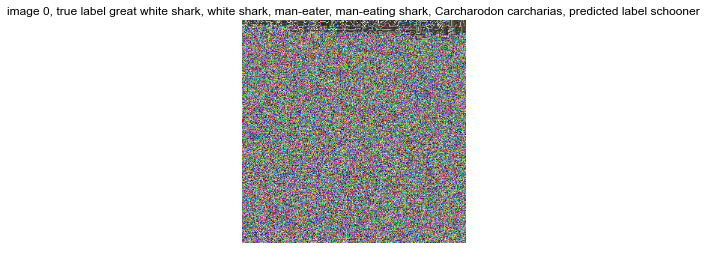

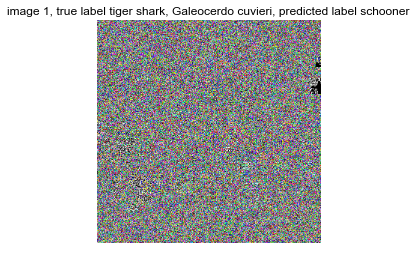

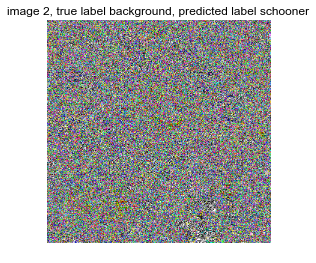

In [21]:
import tensorflow.contrib.slim.nets as nets

with tf.Graph().as_default():
    BATCH = 3
    #image_node = tf.random_uniform([BATCH, HEIGHT, WIDTH, 3], maxval=1)
    #label_node = tf.constant(1, shape = [BATCH], dtype=tf.int32)  
    image_node, image_raw_node, label_node = create_data_tensors_raw(BATCH)
    #image_node, label_node = create_data_tensors(BATCH)
    logit_node, _ = nets.inception.inception_v3(image_node, is_training=False)
    prob_node = tf.nn.softmax(logit_node)
    sv = tf.train.Supervisor(logdir=inception_folder)
    with sv.managed_session() as sess:  
        with slim.queues.QueueRunners(sess):
            #image_batch, true_label_batch, logits_batch = sess.run([image_node, label_node, logit_node])
            image_batch, true_label_batch, logits_batch = sess.run([image_raw_node, label_node, logit_node])
            # image_batch is B * H * W * 3, logits_batch is B * C
            for i in xrange(BATCH): 
                image = image_batch[i, :, :, :]
                true_label = true_label_batch[i]
                logits = logits_batch[i, :]
                predicted_label = np.argmax(logits)
                predicted_name = labels_to_names[predicted_label] # because inception was trained on imagenet
                true_name = labels_to_names[true_label] # this only works if dataset is imagenet!
                str = 'image {}, true label {}, predicted label {}'.format(i, true_name, predicted_name)
                
                plt.figure()
                plt.imshow(image)
                plt.title(str)
                plt.axis('off')
                plt.show()

### Fine-tune the model on a different set of labels.

We will fine tune the inception model on the cifar10 dataset.

In [26]:
def get_init_fn(checkpoint_path, exclusions):
  """Returns a function run by the chief worker to warm-start the training.
  Note that the init_fn is only run when initializing the model during the very
  first global step.
  Returns:
    An init function run by the supervisor.
  """
  variables_to_restore = []
  for var in slim.get_model_variables():
    excluded = False
    for exclusion in exclusions:
      if var.op.name.startswith(exclusion):
        excluded = True
        break
    if not excluded:
      variables_to_restore.append(var)
  return slim.assign_from_checkpoint_fn(
      checkpoint_path,
      variables_to_restore)


    
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    checkpoint_path = tf.train.latest_checkpoint(inception_folder)
    checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]
    new_checkpoint_dir = '/tmp/tf/model{}'.format(time.time())
    
    #images, images_raw, labels = create_data_tensors_raw()
    images, labels = create_data_tensors()
  
    # Create the model:
    logits, _ = nets.inception.inception_v3(images, is_training=True, num_classes=dataset.num_classes)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.scalar_summary('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=new_checkpoint_dir,
        init_fn=get_init_fn(),
        number_of_steps=10)
        
  
print('Finished training. Last batch loss {}'.format(final_loss))

ValueError: Shapes (32, 1000) and (32, 5) are incompatible

### Apply fine tuned model to some images.

In [ ]:
import tensorflow.contrib.slim.nets as nets

with tf.Graph().as_default():
    BATCH = 3
    #image_node = tf.random_uniform([BATCH, HEIGHT, WIDTH, 3], maxval=1)
    #label_node = tf.constant(1, shape = [BATCH], dtype=tf.int32)  
    #image_node, image_raw_node, label_node = create_data_tensors_raw(BATCH)
    image_node, label_node = create_data_tensors(BATCH)
    logit_node, _ = nets.inception.inception_v3(image_node, is_training=False)
    prob_node = tf.nn.softmax(logit_node)
    sv = tf.train.Supervisor(logdir=inception_folder)
    with sv.managed_session() as sess:  
        with slim.queues.QueueRunners(sess):
            image_batch, true_label_batch, logits_batch = sess.run([image_node, label_node, logit_node])
            #image_batch, true_label_batch, logits_batch = sess.run([image_raw_node, label_node, logit_node])
            # image_batch is B * H * W * 3, logits_batch is B * C
            for i in xrange(BATCH): 
                image = image_batch[i, :, :, :]
                true_label = true_label_batch[i]
                logits = logits_batch[i, :]
                predicted_label = np.argmax(logits)
                predicted_name = labels_to_names[predicted_label] # because inception was trained on imagenet
                true_name = labels_to_names[true_label] # this only works if dataset is imagenet!
                str = 'image {}, true label {}, predicted label {}'.format(i, true_name, predicted_name)
                
                plt.figure()
                plt.imshow(image)
                plt.title(str)
                plt.axis('off')
                plt.show()